In [18]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# Task 0
Data extraction: get the data from 3 tables & combine it into single `.csv` file.
After that read this file using pandas to create Dataframe.
So it will be all joined data in 1 dataframe. Quick check - should be 74818 rows in it.

In [32]:
connection = sqlite3.connect("../db.sqlite3")
table1_data = pd.read_sql_query("SELECT * FROM main.restaurant_order", connection)
table1_data.to_csv("order.csv", index=False)

table2_data = pd.read_sql_query("SELECT * FROM restaurant_orderitem", connection)
table2_data.to_csv("orderitem.csv", index=False)

table3_data = pd.read_sql_query("SELECT * FROM restaurant_product", connection)
table3_data.to_csv("product.csv", index=False)

# Task 1
Get Top 10 most popular products in restaurant sold by Quantity.
Count how many times each product was sold and create a pie chart with percentage of popularity (by quantity) for top 10 of them.

Example:

![pie chart](../demo/pie.png)

Top 10 Most Popular Products:
                   name  total_quantity
0         Plain Papadum           10648
1            Pilau Rice            6367
2            Plain Naan            4983
3           Garlic Naan            3318
4            Plain Rice            2964
5          Onion Bhajee            2749
6         Mango Chutney            2504
7  Chicken Tikka Masala            2473
8               Chapati            1935
9            Mint Sauce            1840


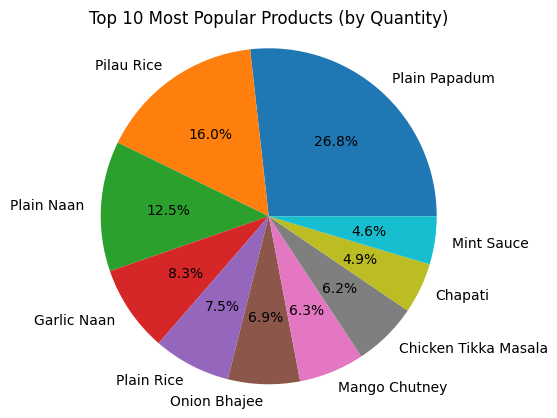

In [33]:
query = """
    SELECT rp.name, SUM(roi.quantity) AS total_quantity
    FROM restaurant_orderitem AS roi
    INNER JOIN restaurant_product AS rp ON roi.product_id = rp.id
    GROUP BY rp.name
    ORDER BY total_quantity DESC
    LIMIT 10
"""
top_products = pd.read_sql_query(query, connection)

print("Top 10 Most Popular Products:")
print(top_products)

labels = top_products["name"]
quantities = top_products["total_quantity"]

plt.pie(quantities, labels=labels, autopct="%1.1f%%")
plt.axis("equal")
plt.title("Top 10 Most Popular Products (by Quantity)")
plt.show()
connection.close()

# Task 2
Calculate `Item Price` (Product Price * Quantity) for each Order Item in dataframe.
And Make the same Top 10 pie chart, but this time by `Item Price`. So this chart should describe not the most popular products by quantity, but which products (top 10) make the most money for restaurant. It should be also with percentage.

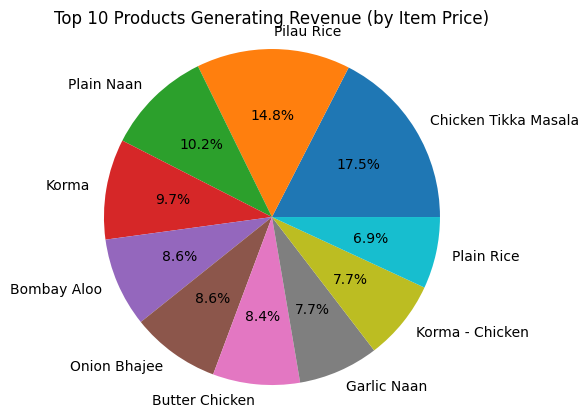

In [34]:
order_items = pd.read_csv("orderitem.csv")
products = pd.read_csv("product.csv")

merged_data = pd.merge(order_items, products, left_on="product_id", right_on="id")

merged_data["Item Price"] = merged_data["quantity"] * merged_data["price"]

top_products = merged_data.groupby("name")["Item Price"].sum().nlargest(10)

labels = top_products.index
revenues = top_products.values

plt.pie(revenues, labels=labels, autopct="%1.1f%%")
plt.axis("equal")
plt.title("Top 10 Products Generating Revenue (by Item Price)")
plt.show()

# Task 3
Calculate `Order Hour` based on `Order Datetime`, which will tell about the specific our the order was created (from 0 to 23). Using `Order Hour` create a bar chart, which will tell the total restaurant income based on the hour order was created. So on x-axis - it will be values from 0 to 23 (hours), on y-axis - it will be the total sum of order prices, which were sold on that hour.

Example:

![bar chart](../demo/bar.png)

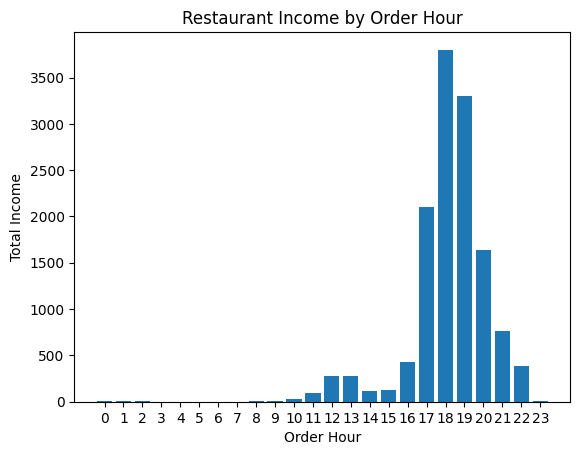

In [35]:
orders = pd.read_csv("order.csv")

# Convert the order datetime column to datetime type
orders["datetime"] = pd.to_datetime(orders["datetime"])

# Extract the order hour from the order datetime
orders["order_hour"] = orders["datetime"].dt.hour

# Calculate the total sum of order prices for each hour
hourly_income = orders.groupby("order_hour")["id"].count()

# Create a bar chart to visualize the total restaurant income based on the order hour
plt.bar(hourly_income.index, hourly_income.values)
plt.xlabel("Order Hour")
plt.ylabel("Total Income")
plt.title("Restaurant Income by Order Hour")
plt.xticks(range(24))
plt.show()

# Task 4
Make similar bar chart, but right now with `Order Day Of The Week` (from Monday to Sunday), and also analyze total restaurant income by each day of the week.

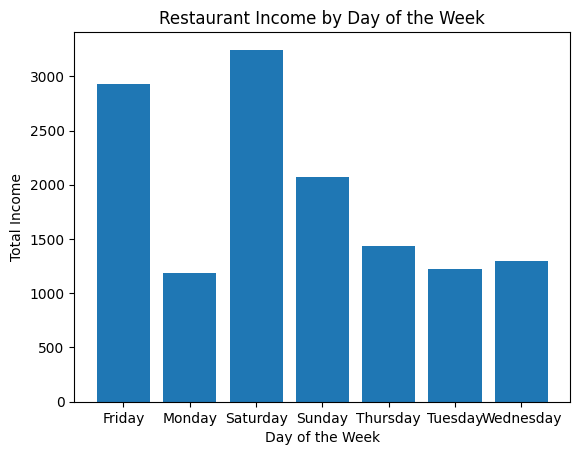

In [36]:
orders["datetime"] = pd.to_datetime(orders["datetime"])

# Extract the day of the week from the order datetime
orders["order_day_of_week"] = orders["datetime"].dt.dayofweek

# Map day of week values to corresponding names
day_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
orders["order_day_of_week"] = orders["order_day_of_week"].map(lambda x: day_names[x])

# Calculate the total sum of order prices for each day of the week
daily_income = orders.groupby("order_day_of_week")["id"].count()

# Create a bar chart to visualize the total restaurant income based on the day of the week
plt.bar(daily_income.index, daily_income.values)
plt.xlabel("Day of the Week")
plt.ylabel("Total Income")
plt.title("Restaurant Income by Day of the Week")
plt.show()